Why are we interested in finding vanishing points? Because they allow us to quickly and easily estimate key parameters about a camera. For example, its focal length, optical centre and rotation in 3D space. 

However, the first step is to identify the location of the vanishing points in an image. 

:::{.callout-important}

The projection of parallel lines in 3D space intersect at a vanishing point in 2D space.

:::

Sometimes it can be easy to find the location of a vanishing point in an image, for example, when two objects in the real world are very long and quite close together, for example, train tracks. Often it's a lot more challenging. 

Let's use a semi-realistic image; I've chosen a rendered image from a video game (Counter-Strike). This means that we can, for the moment, ignore some other factors like *Radial Distortion*. 


Let's start, as always, by importing what we will need later.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import json
import numpy as np
plt.rcParams['figure.figsize'] = [15, 15]

Now let's visualise the scene.

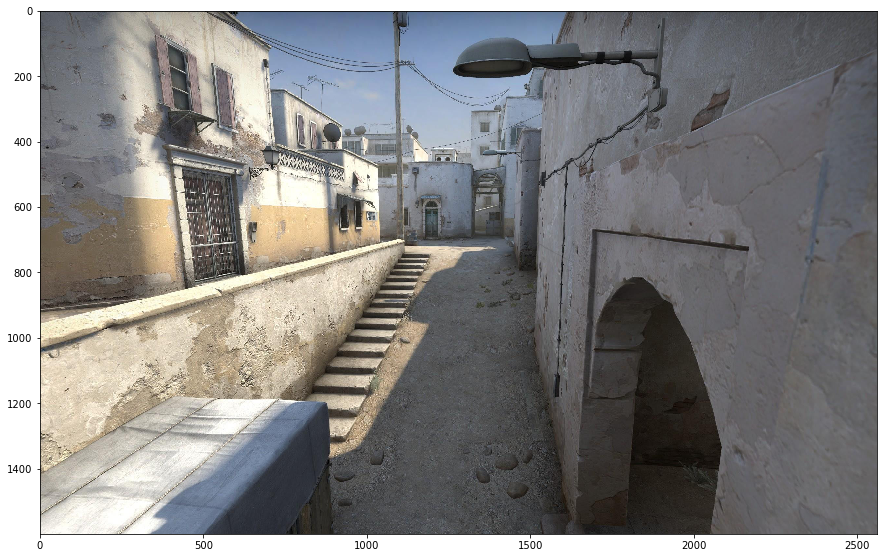

In [2]:
img = Image.open('data/2020-04-10-Finding-Vanishing-Points/csgo-dust2-mid.jpeg')
plt.imshow(img)
plt.show()

## Maximum Likelihood Estimate
An ideal camera maps straight lines in 3D space to straight lines in 2D space. We can automate the detection of straight lines using algorithms like a hough transform. However, I've used an external program to annotate the image's straight lines manually. I've annotated three sets of lines that correspond to one of 3 different vanishing points. 

Often, we use a *manhattan world* assumption, assuming that there are three different sets of orthogonal parallel lines present in the world. 

We assume that two orthogonal lines form the ground plane. In an image, each set of parallel lines on this plane intersects at the horizon. 

![An annotated image](../images/2020-04-10-Finding-Vanishing-Points/Annotated.jpg)

Now, let's use linear algebra and least mean squares (and the magic of [Stack Overflow](https://stackoverflow.com/questions/52088966/nearest-intersection-point-to-many-lines-in-python)) to find one of the vanishing points. 

In [3]:
JSON = json.loads(open('data/2020-04-10-Finding-Vanishing-Points/csgo-dust2-mid.json','r').read())

In [4]:
def intersect_multiple_lines(P0,P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    
    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    
    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return(p)

In [5]:
def load_line_data(point_name):
    P0 = []
    P1 = []
    for shape in JSON['shapes']:
        points = shape['points']
        if shape['label'] == point_name:
            P0.append(points[0])
            P1.append(points[1])
            
    P0 = np.array(P0,dtype=np.float64)
    P1 = np.array(P1,dtype=np.float64)
    return(P0,P1)

def find_vanishing_point(point_name):
    P0,P1 = load_line_data(point_name)
    p = intersect_multiple_lines(P0,P1).ravel()
    return(p)

p = find_vanishing_point(point_name='VP1')

Now let's visualise the location of vanishing point 1.

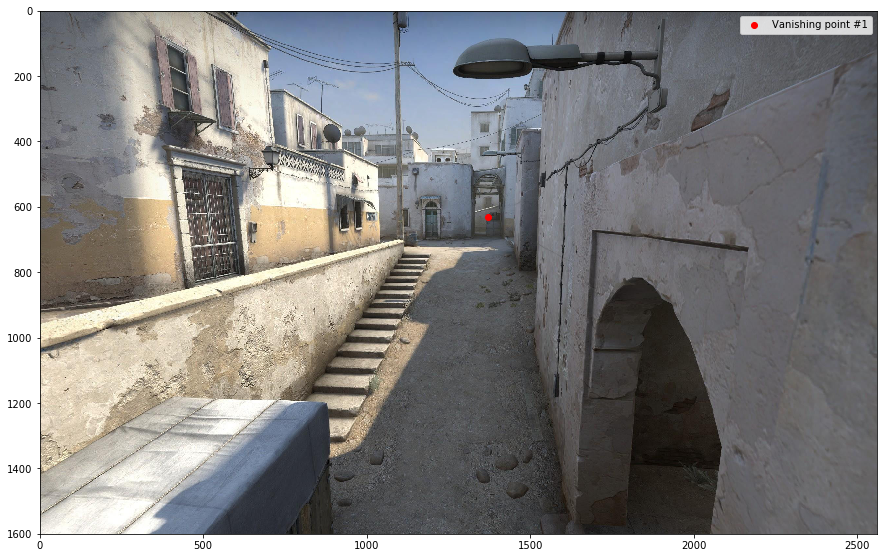

In [6]:
plt.imshow(img)
plt.scatter(p[0],p[1],color='r',label='Vanishing point #1')
plt.legend()
plt.xlim(0,2560)   
plt.ylim(1600,0)
plt.show()

## Monte Carlo Simulation

This is a good start, but I'm interested in how certain we are about the vanishing point. 

For example, when I annotated the lines, I most likely made mistakes in the precise location of each point. We would expect that shorter lines would have a more significant impact on the vanishing point location than longer lines. 

Let's do a *Monte Carlo simulation*, to find the distribution of possible vanishing points.

In [7]:
def monte_carlo_simulation(point_name):
    P0,P1 = load_line_data(point_name)
    
    point_error_magnitude = 1 
    vanishing_points = []
    for i in range(0,1000):
        P0_stochastic = P0 + point_error_magnitude*np.random.randn(P0.shape[0],P0.shape[1])
        P1_stochastic = P1 + point_error_magnitude*np.random.randn(P1.shape[0],P1.shape[1])
        p = intersect_multiple_lines(P0_stochastic,P1_stochastic)
        vanishing_points.append(p)
    vanishing_points = np.asarray(vanishing_points)
    return(vanishing_points)


point_name = 'VP1'
vanishing_points = monte_carlo_simulation(point_name)

Now let's visualise the distribution of points:

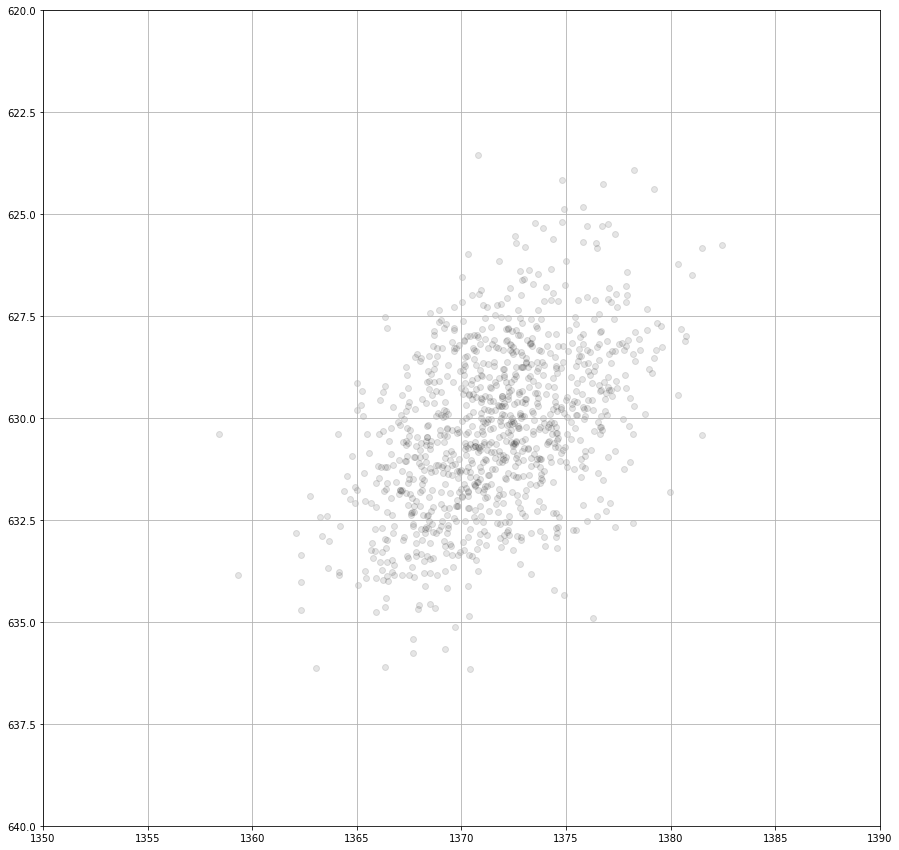

In [8]:
for p in vanishing_points:
    plt.scatter(p[0],p[1],color='k',alpha=0.1)

plt.xlim(1350,1390)   
plt.ylim(640,620)
plt.grid()
plt.show()

For completeness, we can compute the standard deviation of the points in both the x & y-axis.

In [9]:
print(vanishing_points.std(axis=0).ravel())

[3.5399997  2.03944019]


Voilà, we have a standard deviation of ±3.5 pixels in the x-direction and ±2 pixels in the y-direction.

## Appendix
For completeness, let's compute the location of the other three vanishing points.

VP1 [1371.89171088  630.42051773]
VP2 [-10651.53961582    536.68080631]
VP3 [1272.22463298 7683.01978252]


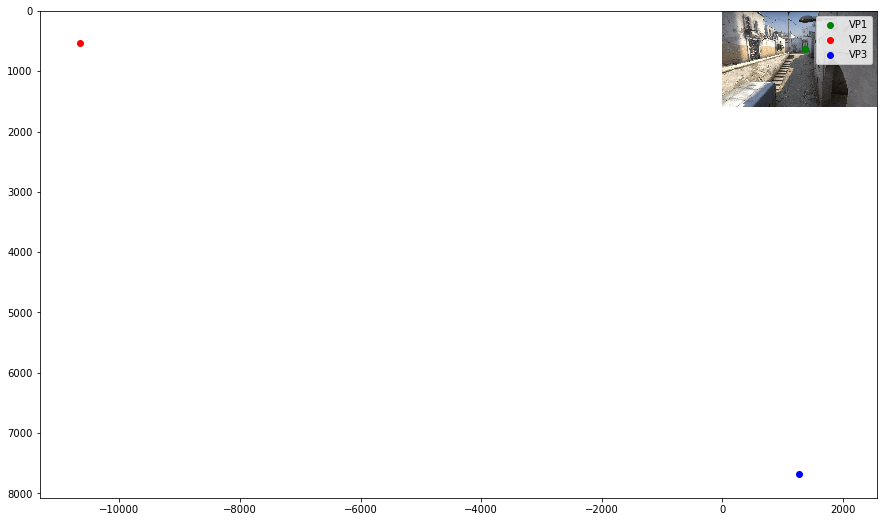

In [12]:
vanishing_points = {}
for point_name in ['VP1','VP2','VP3']:
    vanishing_points[point_name]= find_vanishing_point(point_name)


plt.imshow(img)
for point_name,color in [('VP1','g'),('VP2','r'),('VP3','b')]:
    vp = vanishing_points[point_name]
    print(point_name,vp)
    plt.scatter(vp[0],vp[1],color=color,label=point_name)
plt.legend()
plt.show()


VP1 [3.29072559 2.01278422]
VP2 [1706.16058495   32.11479688]
VP3 [ 20.31361393 217.79742705]


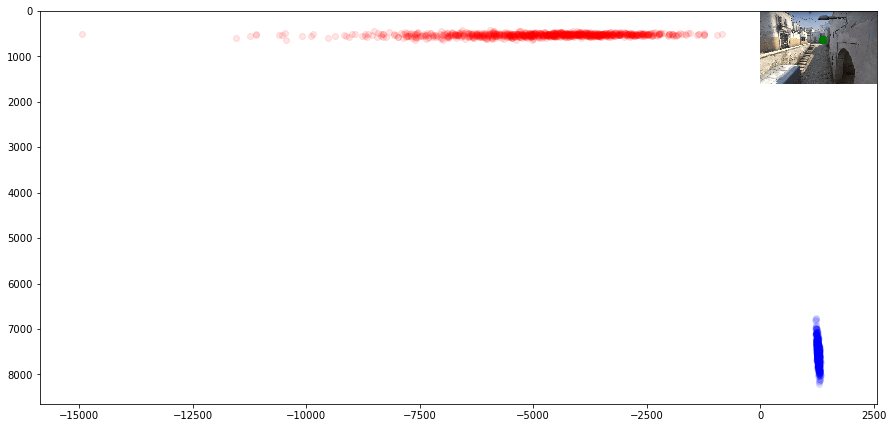

In [11]:
plt.imshow(img)
for point_name,color in [('VP1','g'),('VP2','r'),('VP3','b')]:
    vanishing_points = monte_carlo_simulation(point_name)
    print(point_name, vanishing_points.std(axis=0).ravel())
    
    for p in vanishing_points:
        plt.scatter(p[0],p[1],color=color,alpha=0.1)

plt.show()

We can see that there is a significant amount of uncertainty in the x component (±1728) of the 2nd vanishing point. This is because of the lack of good, long parallel lines running left/right across the image. 